In [42]:
import sys
import os
SRC_SUBDIR = '../..'
SRC_SUBDIR = os.path.abspath(SRC_SUBDIR)
if SRC_SUBDIR not in sys.path:
    sys.path.insert(1, SRC_SUBDIR)

In [43]:
import matplotlib.pyplot as plt
import numpy as np
from src.operators.SympyWrapper import SympyWrap

In [44]:
rosenb_expr = "(a-x)**2+b*(y-x**2)**2"
rosenb = SympyWrap.from_string(rosenb_expr).partial_eval({"a":1, "b":100})
print("symbols : ", rosenb.symbols)
print("function: ", rosenb)
global_min = np.array([1,1])

symbols :  {x, y}
function:  (1.0 - x)**2 + 100.0*(-x**2 + y)**2


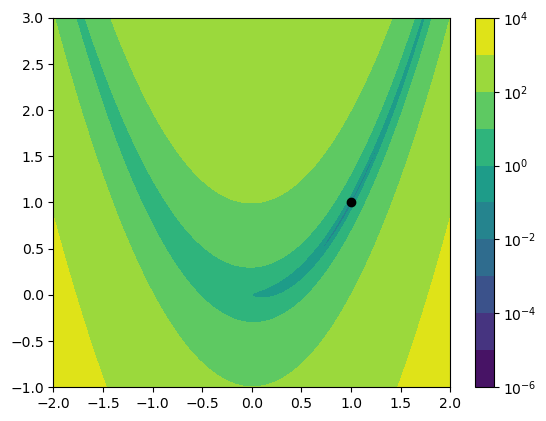

In [45]:
nx, ny = (400, 400)
xmin, xmax = -2,2
ymin, ymax =  -1,3
x = np.linspace(xmin, xmax, nx)
y = np.linspace(ymin, ymax, ny)
xv, yv = np.meshgrid(x, y)
xx= np.array([xv, yv])
vals = rosenb(xx, ['x','y'])
from matplotlib import ticker
fig, ax = plt.subplots()
im=plt.contourf(x,y,vals, locator=ticker.LogLocator(numticks=20))
plt.plot(global_min[0], global_min[1], marker='o', color='k', linestyle='none')
plt.colorbar(im)
plt.show()

In [46]:
import copy
from scipy.optimize import line_search
from functools import partial

class GradientDescent:

    def __init__(self, func, vars, stepl=1.0, niters=10, linesearch = False):
        self.func = partial(func, symbol_names=vars)
        self._symgrad = func.jac(vars)
        self.grad = partial(self._symgrad, symbol_names=vars)
        #self.vars = vars
        self.stepl = stepl
        self.niters = niters
        self.use_linesearch = linesearch

    def compute_step(self, x, gx):
        if self.use_linesearch:
            step = line_search(self.func, self.grad, x, -gx)[0]
            if step is None:
                step = self.stepl
        else:
            step = self.stepl
        return x - step*gx

    def solve(self, x0):
        x=copy.deepcopy(x0)
        iterations=[]
        for _ in range(self.niters):
            iterations.append(x)
            gx = self.grad(x)
            x = self.compute_step(x, gx)
        return iterations


In [51]:
def plot_convergence(iterations, solver_type):
    convergence = []
    for iteration in iterations:
        dist = np.sqrt(np.sum((iteration-global_min)**2))
        convergence.append(dist)
        plt.plot(iteration[0], iteration[1], marker='x', color="blue", linestyle='none')
    plt.plot(global_min[0], global_min[1], marker='o', color='k', linestyle='none')
    plt.xlim((xmin, xmax))
    plt.ylim((ymin, ymax))
    im=plt.contourf(x,y,vals, locator=ticker.LogLocator(numticks=20))
    plt.colorbar(im)
    plt.show()

    plt.semilogy(convergence)
    plt.title(f"convergence for {solver_type}")
    plt.show()

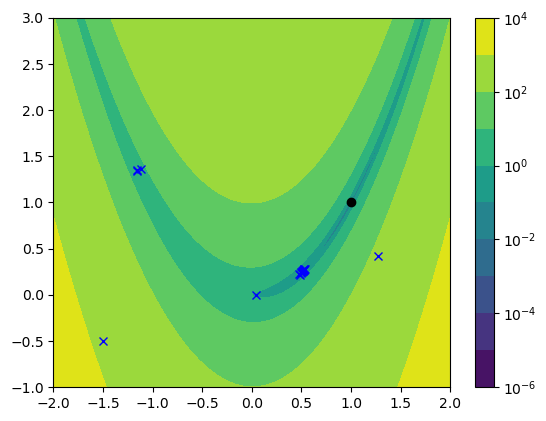

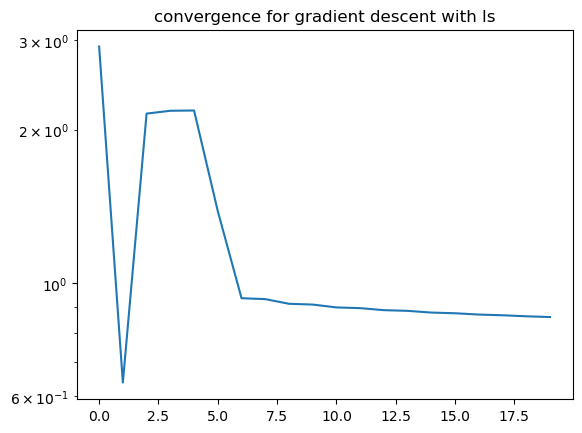

In [52]:
vars = ['x','y']
x0 = np.array([-1.5,-0.5])
solver = GradientDescent(rosenb, vars, stepl=0.01, niters=20, linesearch=True)
iterations = solver.solve(x0)
plot_convergence(iterations, "gradient descent with ls")

In [53]:
class NewtonDescent(GradientDescent):

    def __init__(self, func, vars, niters=10):
        super().__init__(func, vars, 1.0, niters)
        self.hess = partial(self._symgrad.jac(vars), symbol_names = vars)

    def compute_step(self, x, gx):
        Hx = self.hess(x)
        return x-np.linalg.inv(Hx).dot(gx)
    

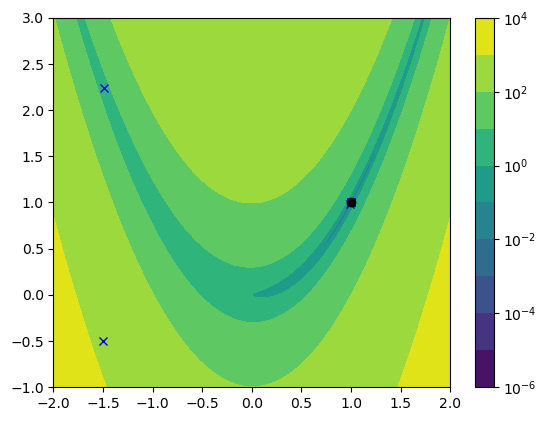

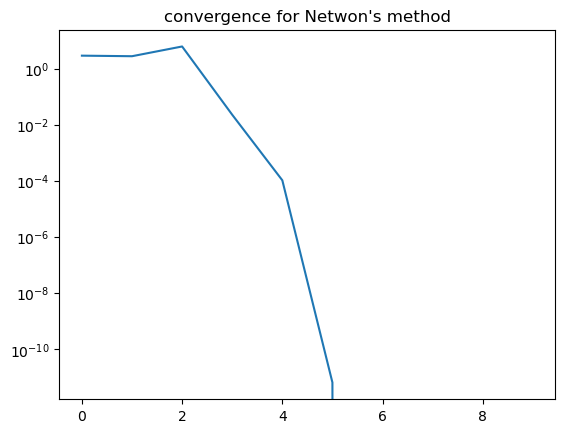

In [ ]:
vars = ['x','y']
solver = NewtonDescent(rosenb, vars, niters=10)
iterations = solver.solve(x0)
plot_convergence(iterations, "Newton's method")